# Identyfikacja Automatów Komórkowych

Wykład: https://github.com/houp/ca-class/blob/main/slides/lecture8.pdf

### Importy

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## zad.15
Zaimplementuj prosty algorytm identyfikacji CA na podstawie obserwacji. \
Założenia:
- Dana jest obserwacja, która nie zawiera tzw. "dziur czasowych" (temporal gaps). Innymi słowy każde dwa kolejne wiersze obserwacji odpowiadają dwum kolejnym krokom czasu CA.
- Obserwacja może zawierać dziury (spatial gaps) w pojedynczych komórkach. Są one oznaczone przez “stan” o wartości -1.
- **Opcja łatwiejsza:** zakładamy, że promień sąsiedztwa jest znany i podany jako argument funkcji.
- Opcja trudniejsza: zakładamy, że nie jest znany promień sąsiedztwa i trzeba znaleźć automat o najmniejszym promieniu.
- Opcja bardziej trudniejsza: zakładamy, że w obserwacji może pojawić się szum - tzn. zaobserwowane stany niektórych komórek mogą być błędne (zaobserwowano 1 a było 0 i vice versa).

Podpowiedzi:
- Nie ma dziur czasowych, więc nie trzeba robić algorytmu ewolucyjnego!
- Wystarczy przejrzeć całą obserwację i spróbować "odczytać" regułę.
- Trzeba się zastanowić co zrobić w przypadku gdy pewnych konfiguracji sąsiedztw w ogóle nie zaobserwowano. Co wtedy? 
- Warto napisać sobie własny test do tego algorytmu na podstawie stworzonej na wcześniejszych zajęciach generujących diagramy czaso-przestrzenne. Losujemy 
regułę. Generujemy diagram czasoprzestrzenny. Odpalamy nasz algorytm identyfikacji i sprawdzamy czy wykrył tą samą regułę od której wystartowaliśmy.

In [2]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)

def plot_space_time(spacetime):
    cmap = colors.ListedColormap(['gray', 'white', 'black'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(5, 5))
    plt.imshow(spacetime, cmap=cmap, norm=norm, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [3]:
lut = eca_get_lut(random.randrange(0,256))
print(f'lut: {lut}, reguła: {np.packbits(lut)[0]}')
initial_conf = np.random.randint(0,2,25)

lut: [1 0 1 0 1 0 0 0], reguła: 168


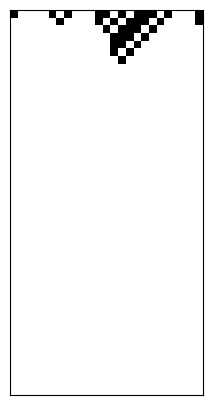

In [4]:
spacetime = eca_evolve_spacetime(lut, initial_conf, 50)
plot_space_time(spacetime)

### Funkcja dodająca dziury (spatial gaps) w komórkach

In [5]:
def generate_observation(spacetime: np.ndarray, percent: float) -> np.ndarray:
    spacetime_copy = spacetime.copy()
    total_cells = spacetime_copy.size
    num_gaps = int(total_cells * percent)
    
    for _ in range(num_gaps):
        row = np.random.randint(1, spacetime_copy.shape[0])
        col = np.random.randint(spacetime_copy.shape[1])
        spacetime_copy[row, col] = -1
    
    return spacetime_copy


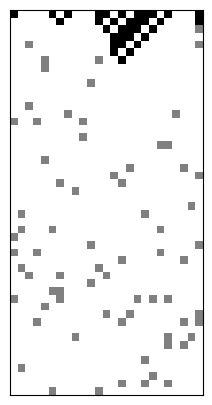

In [6]:
spacetime2 = generate_observation(spacetime, 0.06)
plot_space_time(spacetime2)

### Prototyp funkcji do identyfikacji CA

In [7]:
def ca_identify(spacetime: np.ndarray) -> np.ndarray:
    lut = np.full(8, -1, dtype=np.int8)
    for t in range(spacetime.shape[0]-1):
        for x in range(spacetime.shape[1]):
            neighborhood = np.array([np.roll(spacetime[t],1)[x], spacetime[t, x], np.roll(spacetime[t],-1)[x]])
            if -1 not in neighborhood and spacetime[t+1, x] != -1:
                lut[7-int(''.join(map(str, neighborhood)), 2)] = spacetime[t+1, x]
    # jeśli nie ma jakiejś konfiguracji - w ten sposób nie znajdziemy reguł typu 0 czy 256
    if -1 in lut:
        return 'Lut not found'
    return lut


Sprawdzenie dla diagramu bez brakujących wartości:

In [8]:
print(f'Początkowy lut: {lut}, reguła: {np.packbits(lut)[0]}')
identified_lut = ca_identify(spacetime)
print(f'Znaleziony lut: {identified_lut}')
if type(identified_lut) != str:
    print(f'Reguła: {np.packbits(identified_lut)[0]}')

Początkowy lut: [1 0 1 0 1 0 0 0], reguła: 168
Znaleziony lut: [1 0 1 0 1 0 0 0]
Reguła: 168


Sprawdzenie dla diagramu z brakującymi wartościami:

In [9]:
print(f'Początkowy lut: {lut}, reguła: {np.packbits(lut)[0]}')
identified_lut2 = ca_identify(spacetime2)
print(f'Znaleziony lut: {identified_lut2}')
if type(identified_lut2) != str:
    print(f'Reguła: {np.packbits(identified_lut2)[0]}')

Początkowy lut: [1 0 1 0 1 0 0 0], reguła: 168
Znaleziony lut: [1 0 1 0 1 0 0 0]
Reguła: 168


### Funckja z parametrem r - promień sąsiedztwa

In [10]:
def ca_identify(spacetime: np.ndarray, r: int) -> np.ndarray:
    lut = np.full(2**(2*r + 1), -1, dtype=np.int8)
    for t in range(spacetime.shape[0] - 1):
        for x in range(spacetime.shape[1]):
            neighborhood = np.array([np.roll(spacetime[t], i)[x] for i in range(r, -r-1, -1)])
            if -1 not in neighborhood and spacetime[t+1, x] != -1:
                lut[2**(2*r + 1)-1 - int(''.join(map(str, neighborhood)), 2)] = spacetime[t+1, x]
    if -1 in lut:
        return 'Lut not found'
    return lut


In [11]:
print(f'Początkowy lut: {lut}, reguła: {np.packbits(lut)[0]}')
identified_lut = ca_identify(spacetime, 1)
print(f'Znaleziony lut: {identified_lut}')
if type(identified_lut) != str:
    print(f'Reguła: {np.packbits(identified_lut)[0]}')

Początkowy lut: [1 0 1 0 1 0 0 0], reguła: 168
Znaleziony lut: [1 0 1 0 1 0 0 0]
Reguła: 168


In [12]:
print(f'Początkowy lut: {lut}, reguła: {np.packbits(lut)[0]}')
identified_lut2 = ca_identify(spacetime2, 1)
print(f'Znaleziony lut: {identified_lut2}')
if type(identified_lut2) != str:
    print(f'Reguła: {np.packbits(identified_lut2)[0]}')

Początkowy lut: [1 0 1 0 1 0 0 0], reguła: 168
Znaleziony lut: [1 0 1 0 1 0 0 0]
Reguła: 168


### Sprawdzenie dla sąsiedztwa r = 2

In [13]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(32)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[31 - (np.roll(x, 2) * 16 + np.roll(x, 1) * 8 + x * 4 + np.roll(x, -1) * 2 + np.roll(x, -2)).astype(int)]

In [14]:
lut = eca_get_lut(random.randrange(0,2**32))
rule = int(''.join(map(str, lut)), 2)
print(f'lut: {lut}, reguła: {rule}')
initial_conf = np.random.randint(0,2,51)

lut: [1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1], reguła: 2856335193


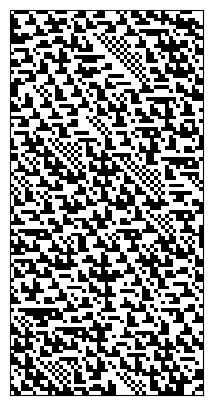

In [15]:
spacetime = eca_evolve_spacetime(lut, initial_conf, 102)
plot_space_time(spacetime)

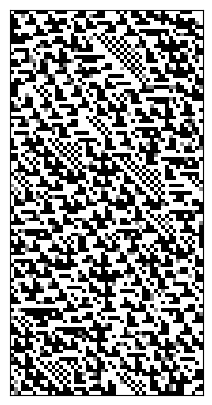

In [16]:
spacetime2 = generate_observation(spacetime, 0.03)
plot_space_time(spacetime2)

In [17]:
print(f'Początkowy lut: {lut}, reguła: {rule}')
identified_lut = ca_identify(spacetime, 2)
print(f'Znaleziony lut: {identified_lut}')
if type(identified_lut) != str:
    identified_rule = int(''.join(map(str, identified_lut)), 2)
    print(f'Reguła: {identified_rule}')

Początkowy lut: [1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1], reguła: 2856335193
Znaleziony lut: [1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1]
Reguła: 2856335193


In [18]:
print(f'Początkowy lut: {lut}, reguła: {rule}')
identified_lut2 = ca_identify(spacetime2, 2)
print(f'Znaleziony lut: {identified_lut2}')
if type(identified_lut2) != str:
    identified_rule2 = int(''.join(map(str, identified_lut2)), 2)
    print(f'Reguła: {identified_rule2}')

Początkowy lut: [1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1], reguła: 2856335193
Znaleziony lut: [1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1]
Reguła: 2856335193
